# Handwritten Digits Recognizer

### Steps

- Load MNIST dataset (handwritten digits) and visualize sample digits
- Write basic preprocessing of dataset: normalize images, split train/test sets.
- Implement first simple feedforward NN
- Train subset (~1-5k images) quick results
- Evaluate accuracy -> even if low
- Upgrade NN to simple CN (1-2 conv layers)
- Train CNN on MNIST -> aim for 95% accuracy
- Log results, plot loss/accuracy curves.
- Finalize CNN -> add droput/batch norm
- Train an ML model (SVM - to compare performance with NN and CNN) 
- save trained model and write simple inference script.
- Optional: create basic CLI to input image and get predicted digits

# Dataset

Content

The MNIST database of handwritten digits has a training set of 60,000 examples, and a test set of 10,000 examples. .

Four files are available:

- train-images-idx3-ubyte.gz: training set images (9912422 bytes)
- train-labels-idx1-ubyte.gz: training set labels (28881 bytes)
- t10k-images-idx3-ubyte.gz: test set images (1648877 bytes)
- t10k-labels-idx1-ubyte.gz: test set labels (4542 bytes)

Goal: To create a CNN that can detect the handwritten digits. In the end I should have a CLI app that I can input an image and output the correct digit.

# First Tasks

- Create reader and plotter for minst dataset
- Visualize the images. 
- Preprocess dataset (Clean, Normalize, etc.)
- Get statistical metrics of dataset and Plot metrics.

IDX format

- Magic Number
- size in dimension 0
- size in dimension 1
- size in dimension 2
- ...
- size in dimension N
- data

magic number is 4 bytes integers with two bytes set as 0 and the other two bytes used to describe:
- basic data type used (3rd byte)
- number of dimensions of the stored array (4th byte)

data types:
- 0x08: unsigned byte 
- 0x09: signed byte 
- 0x0B: short (2 bytes) 
- 0x0C: int (4 bytes) 
- 0x0D: float (4 bytes) 
- 0x0E: double (8 bytes)

4th byte codes the number of dimensions of the vector/matrix:
1 would be for vectors, 2 for two dimension matrices, etc.

Then size of each dimension (4-byte integers, MSB first, big-endian)

data itself is stored in a C array (row-major first) where the index in the last dimension change the fastest



In [23]:
import os
import numpy as np

mnst_dataset = {
    'train_images': 'MNIST_dataset/train-images-idx3-ubyte/train-images-idx3-ubyte',
    'train_labels': 'MNIST_dataset/train-labels-idx1-ubyte/train-labels-idx1-ubyte',
    'test_images': 'MNIST_dataset/t10k-images-idx3-ubyte/t10k-images-idx3-ubyte',
    'test_labels': 'MNIST_dataset/t10k-images-idx1-ubyte/t10k-images-idx1-ubyte',
}

train_images_filepath = os.path.join(os.getcwd(),mnst_dataset.get('train_images'))

with open(train_images_filepath,'rb') as file:
    magic_number = file.read(4) #0 0 (data type) (num of dimensions fo stored arrays)
    dimension_1 = int.from_bytes(file.read(4), byteorder='big', signed=False) # 60000
    dimension_2 = int.from_bytes(file.read(4), byteorder='big', signed=False)# 28
    dimension_3 = int.from_bytes(file.read(4), byteorder='big', signed=False)# 28
    data_np = np.frombuffer(file.read(), dtype=np.uint8) #grayscale (8-bit unsigned integer)
data_np = data_np.reshape(dimension_1,dimension_2,dimension_3) #img pixels (img, row, column)

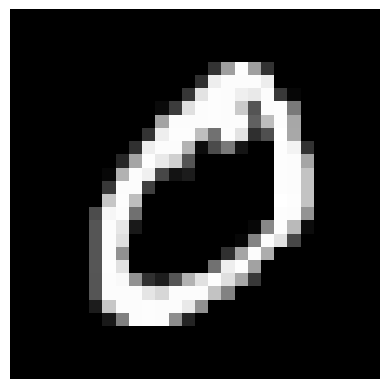

In [29]:
import matplotlib.pyplot as plt
plt.axis('off')
plt.imshow(data_np[1],cmap='gray')

In [131]:
from read_mnist import (
    read_imgages_idx,
    read_labels_idx,
    show_image,
    standardize_data,
    split,
)
from mnist_neural_net import ImageClassifier, ModelTraining

In [138]:
def testsplit(images_data, labels, val_ratio):

    number_of_images = len(labels)
    shuffled_sequence = np.random.permutation(number_of_images)

    shuffled_images = images_data[shuffled_sequence]
    shuffled_labels = labels[shuffled_sequence]
    
    split_index = int((1 - val_ratio) * number_of_images)
    print(split_index)
    X_train = shuffled_images[:split_index]
    X_val = shuffled_images[split_index:]
    y_train = shuffled_labels[:split_index]
    y_val = shuffled_labels[split_index:]

    return X_train, X_val, y_train, y_val

In [ ]:
mnst_dataset = {
    'train_images': 'MNIST_dataset/train-images-idx3-ubyte/train-images-idx3-ubyte',
    'train_labels': 'MNIST_dataset/train-labels-idx1-ubyte/train-labels-idx1-ubyte',
    'test_images': 'MNIST_dataset/t10k-images-idx3-ubyte/t10k-images-idx3-ubyte',
    'test_labels': 'MNIST_dataset/t10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte',
}

train_images_filepath = os.path.join(os.getcwd(),mnst_dataset.get('train_images'))
train_labels_filepath = os.path.join(os.getcwd(),mnst_dataset.get('train_labels'))
test_images_filepath = os.path.join(os.getcwd(),mnst_dataset.get('test_images'))
test_labels_filepath = os.path.join(os.getcwd(),mnst_dataset.get('test_labels'))

train_images = read_imgages_idx(train_images_filepath)
train_labels = read_labels_idx(train_labels_filepath)
test_images = read_imgages_idx(test_images_filepath)
test_labels = read_labels_idx(test_labels_filepath)


In [148]:
X_train, X_val, y_train, y_val = testsplit(train_images, train_labels, 0.2)

X_train_standard = standardize_data(X_train)
X_val_standard = standardize_data(X_val)

48000


In [159]:
import torch
from torch import nn
import matplotlib.pylab as plt
from datetime import datetime

class ImageNeuralNet(nn.Module):
    def __init__(self,image_pixels): # image_pixel = 28*28 => 784
        super().__init__()
        self.fc1 = nn.Linear(image_pixels,512)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(512,128)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(128,64)
        self.relu3 = nn.ReLU()
        self.output_layer = nn.Linear(64,1)

    def forward(self, image):
        x = self.relu1(self.fc1(image))
        x = self.relu2(self.fc2(x))
        x = self.relu3(self.fc3(x))
        x = self.output_layer(x)

        return x

In [163]:
import torch.optim as optim
import torch
from torch import nn

mps_device = torch.device("mps")
image_pixels = 28*28
model = ImageNeuralNet(image_pixels).to(mps_device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_function = nn.BCEWithLogitsLoss()

feedforward_model = ModelTraining(model,optimizer,loss_function)


In [ ]:

training_set = (X_train_standard,y_train)
validation_set = (X_val, y_val) # Probably need to standardize these
feedforward_model.train_loop(training_set, validation_set, 1, 32)

TypeError: linear(): argument 'input' (position 1) must be Tensor, not numpy.ndarray